In [3]:
# Code imports
from lib.opt_types import *
from lib.utils import *

# First Order Methods - 30 points

As a means of estimating the unknown parameter $\mathbf{x}^\natural$, your labor in part 1 led you to define the following optimization problem:
\begin{equation}
	\mathbf{x}^\star=\arg\min_{\mathbf{x} \in \mathbb{R}^p} f_\mu(\mathbf{x}) \equiv  f(\mathbf{x}) + \frac{\mu}{2}\|\mathbf{x}\|_2^2.
\end{equation}

The optimality condition of \eqref{eq:log_problem} is

\begin{equation}
\nabla f_\mu({\mathbf x}^\star) =  \sum_{i=1}^n (\sigma(\mathbf{a}_i^T\mathbf{x}) - b_i)\mathbf{a}_i + \mu \mathbf x^\star = 0. 
\end{equation}

Thanks to convexity, condition \eqref{eq:fixed_point_a} is in fact the necessary and sufficient condition for $\mathbf x^\star$ to be optimal.
We can equivalently write this condition as
\begin{equation}
\mathbf x^\star = {\mathbf x}^\star - \mathbf{B} \nabla f_\mu({\mathbf x}^\star)
\end{equation}
for any symmetric, positive definite matrix $\mathbf{B}$. 
This is a fixed-point formulation of \eqref{eq:log_problem}, which will be used to develop first-order methods.


Notice that choosing $\mathbf{B} = \alpha \mathbb{I}$ with $\alpha > 0$ in the formulation \eqref{eq:fixed_point} suggests that the gradient descent method can be used to solve \eqref{eq:log_problem}. 

In this part, you will implement different variants of the gradient descent algorithm. 


### Code structure:

A `Function` is a type that has the following attributes:

```python
@dataclass
class Function:
    f              # The function that is being minimized
    grad           # The gradient of the function
    f_star         # The minimum of the function
    strng_cvx      # The strong convexity constant, if it admits one
    lips_grad      # The smoothness constant, if it admits one
```

For a given function `f = Function()`:
- You can evaluate the function at a point `x` by simply writing `f(x)`.
- You can evaluate the gradient at a point `x` by writing `f.grad(x)`.
- You can get the smoothness constant by writing `f.lips_grad`.
- You can get the strong convexity constant by writing `f.strng_cvx`



We have defined the function that we are trying to minimize $f_\mu$ and stored in the object `f`, and we have provided you with an inital guess of a solution `x_zero`.

In [4]:
from lib.part_one import f, x_zero

In order for you to test your algorithms, we have also provided you with a `test` function that runs a given method on a strongly convex quadratic function $x \mapsto \frac{1}{2}x^\top M x$ for `100` iterations that we intialize at $x_0 = \begin{bmatrix} 100.0& 100.0 \end{bmatrix}$. For example, once you implement `GD` you can test it by running

```python
test(GD)
```

<div class="alert alert-block alert-success">
<b>Run the cells !</b> Make sure you run all the code cells as some variables are defined and used in mutiple subsequent cells.
</div>

### Variants of Gradient Descent

Now you will implement various methods to iteratively improve the initial guess `x_zero`.

__(a)__ (6 points) The main ingredients of the gradient descent algorithm are the descent direction (the negative gradient) and the step-size $\alpha_k$. 
In this part, we consider the gradient descent algorithm with constant step-size ${1}/{L}$, i.e., $\alpha_k = {1}/{L}$ for any $k = 0,1,...$ where $L$ is the gradient-Lipschitz constant of the function `f`. 

Gradient Descent, as an iterative scheme, only tracks the current iterate `x_k` and the step size `alpha_k`. We store them both in a state variable that holds both these attributes:

In [5]:
@dataclass
class GD_state(OptState):
    x_k: Vector
    alpha_k: float

Given a function `f` and a state at some iteration $k$, recall how GD updates the state and fill in the following cell:

In [6]:
def GD_update(f, state):
    x_k, alpha_k = state
    
    x_next = x_k - alpha_k * f.grad(x_k)
    
    return GD_state(x_k = x_next, alpha_k = alpha_k)

Having defined the `GD_update` which updates a given state, we now need to initialize the state. Fill in the cell below, recalling that you are given an initial guess `x_zero`, and the fact that we are using a fixed step size corresponding to the smoothness constant of `f`.

In [7]:
def GD_initialize(f, x_zero):
    x_k = x_zero
    alpha_k = 1/f.lips_grad
    return GD_state(x_k, alpha_k)

With the initialization and the update scheme specified, we define the algorithm in the cell below:

In [8]:
GD = OptAlgorithm(name="GD", init_state = GD_initialize, state_update = GD_update)

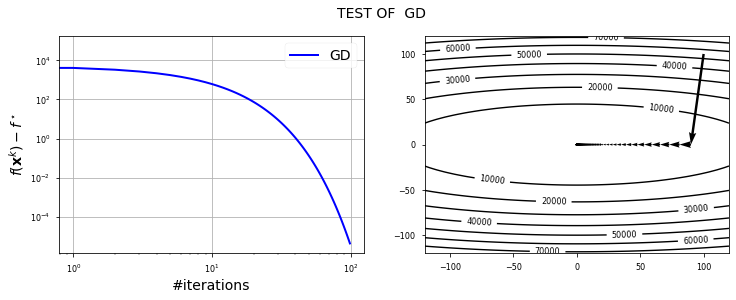

In [9]:
test(GD)

We now notice that the objective function is strongly convex. Therefore, we can select the constant step-size $\alpha$ as $2/(L+\mu)$ to get a faster convergence rate. We call this algorithm `GDstr`.

Both `GD` and `GDstr` have the same state update but only differ in the stepsize they use. Implement this variant of the gradient descent method by completing the code:

In [10]:
def GDstr_initialize(f, x_zero):
    x_k = x_zero
    alpha_k = 2/(f.lips_grad+ f.strng_cvx)
    return GD_state(x_k, alpha_k)
    
GDstr = OptAlgorithm(name="GDstr", init_state = GDstr_initialize, state_update = GD_update)

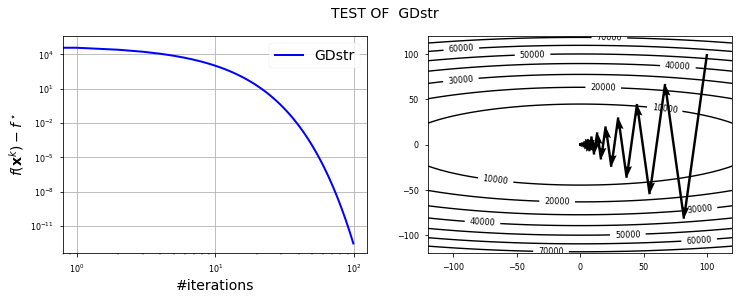

In [11]:
test(GDstr)

__(b)__ (7 points) We can accelerate the above gradient descent algorithm with the following scheme ($t_0=1$):

\begin{equation*}
\begin{array}{ll}
\mathbf{x}^{k+1} &:=  \mathbf{y}^k - \alpha_k\nabla{f_\mu}(\mathbf{y}^k),\\
t_{k+1} &:= \frac{1}{2}(1 + \sqrt{1 + 4t_k^2})\\
\mathbf{y}^{k+1} &:= \mathbf{x}^{k+1} + \frac{t_k-1}{t_{k+1}}\big(\mathbf{x}^{k+1} - \mathbf{x}^k\big).
\end{array}
\end{equation*}

Implement this algorithm with constant step-size $\alpha = 1/L$, by completing the missing parts of the following cells.

First we define the state that the algorithm updates at each iteration:

In [12]:
@dataclass
class AGD_state(OptState):
    x_k: Vector
    y_k: Vector
    t_k: float
    alpha_k: float

Given this `state` and a function `f` to optimize, write the update step of accelerated gradient descent:

In [13]:
def AGD_update(f, state):
    x_k, y_k, t_k, alpha_k = state
    
    next_x_k = y_k - alpha_k * f.grad(y_k)
    next_t_k = (1+ (1+4*t_k**2)**0.5)/2
    next_y_k = next_x_k + (t_k - 1)*(next_x_k - x_k)/next_t_k
    next_alpha_k = 1/f.lips_grad
    
    return AGD_state(x_k = next_x_k, y_k = next_y_k, t_k=next_t_k, alpha_k =next_alpha_k)

Define the initial state of AGD in the cell below:

In [14]:
def AGD_initialize(f, x_zero):
    return AGD_state(x_k = x_zero, y_k = x_zero, t_k=1, alpha_k =1.0/f.lips_grad)

We have all the necessary ingredients to define the optimization algorithm in the following cell:

In [15]:
AGD = OptAlgorithm(name="AGD", init_state=AGD_initialize, state_update=AGD_update)

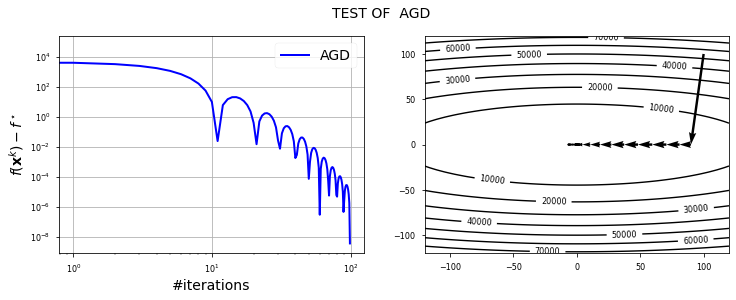

In [16]:
test(AGD)

Note that the objective function is strongly convex. Therefore, we can use the accelerated gradient algorithm for strongly convex objectives to converge faster. This variant can be summarized as follows:

\begin{equation*}
\left\{
\begin{array}{ll}
    \mathbf{x}^{k+1} &:=  \mathbf{y}^k - \alpha_k\nabla{f_\mu}(\mathbf{y}^k),\\
    \mathbf{y}^{k+1} &:= \mathbf{x}^{k+1} + \frac{\sqrt{L}-\sqrt{\mu}}{\sqrt{L}+\sqrt{\mu}}\big(\mathbf{x}^{k+1} - \mathbf{x}^k\big).
\end{array}
\right.
\end{equation*}
 
Implement this variant of the accelerated gradient method by completing the following cells.

In [17]:
@dataclass
class AGDstr_state(OptState):
    x_k: Vector
    y_k: Vector
    alpha_k: float

In [18]:
def AGDstr_update(f, state):
    
    x_k, y_k, alpha_k = state
    L = f.lips_grad
    u = f.strng_cvx
    
    next_x_k = y_k - alpha_k*f.grad(y_k)
    next_y_k = next_x_k + (L**0.5 - u**0.5)*(next_x_k - x_k)/(L**0.5 + u**0.5)
    
    return AGDstr_state(next_x_k, next_y_k, alpha_k)

def AGDstr_initialize(f, x_zero):
    x_k = x_zero
    y_k = x_zero
    alpha_k = 1/f.lips_grad
    
    return AGDstr_state(x_k, y_k, alpha_k)

In [19]:
AGDstr = OptAlgorithm(name="AGDstr", init_state=AGDstr_initialize, state_update=AGDstr_update)

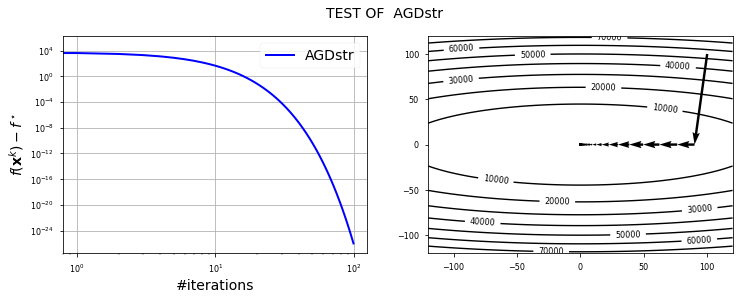

In [20]:
test(AGDstr)

__(c)__ (5 points) We can obtain better performance by considering a line search procedure, which adapts the step-size $\alpha_k$ to the local geometry. 
The line-search strategy to determine the step-size $\alpha_k$ for the standard GD algorithm,
$\mathbf{x}^{k+1}=\mathbf{x}^k-\alpha_k\nabla f_\mu(\mathbf{x}^k),$
is the following: 

At the step $kth$ iteration, let $\mathbf{x}^k$ be the current iterate and $\mathbf{d}^k=-\nabla f_\mu(\mathbf{x}^k)$ be a given descent direction, and perform:
* Set $L_0 = L$.
* At each iteration, set $L_{k,0} = \frac{1}{2}L_{k-1}$, where $k$ is the iteration counter. 
* Using a while loop, find the minimum integer $i \geq 0$ that satisfies $f_\mu\left(\mathbf{x}^k + \frac{1}{2^i L_{k,0}} \mathbf{d}^k\right) \leq f_\mu(\mathbf{x}^k) -\frac{1}{2^{i+1} L_{k,0}} \|\mathbf{d}^k\|^2$.
* Set $L_k = {2^i L_{k,0}}$ and use the step-size $\alpha_k := \frac{1}{L_k}$ (i.e., use the new estimate that you have used in the line-search: $\mathbf{x}^k + \frac{1}{2^i L_{k,0}} \mathbf{d}^k$).

Complete the missing parts in order to implement gradient descent with line-search.

In [21]:
@dataclass
class LS_GD_state(OptState):
    x_k: Vector
    alpha_k : float

In [22]:
def LS_GD_update(f, state):
    x_k, alpha_k = state
    
    d_k = - f.grad(x_k)
    L_k = 1/alpha_k
    L_k0 = L_k/2
    
    i = 0
    while( f(x_k + d_k/(2**i * L_k0)) > f(x_k) - d_k.dot(d_k)/(2**(i+1) * L_k0)):
        i+=1
    
    next_L_k = 2**i * L_k0
    alpha_k = 1/next_L_k
    next_x_k = x_k + alpha_k * d_k
    
    return LS_GD_state(next_x_k, alpha_k)
    
def LS_GD_initialize(f, x_zero):
    
    x_k = x_zero
    alpha_k = 1/f.lips_grad
    
    return LS_GD_state(x_k, alpha_k)

In [23]:
LS_GD = OptAlgorithm(name="LS_GD", init_state = LS_GD_initialize, state_update=LS_GD_update )

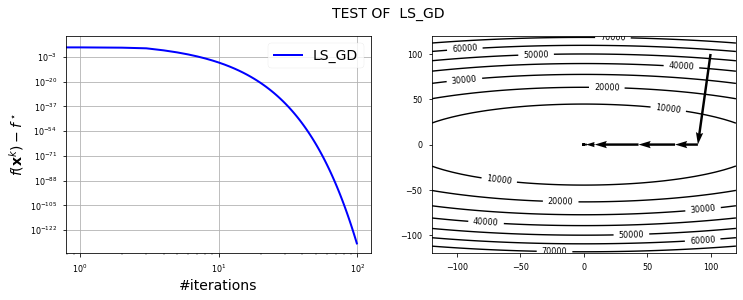

In [24]:
test(LS_GD)

(BONUS) We now incorporate a line-search enhancement to the accelerated gradient method implemented in (b). At step $k$, 
we have the current iteration $\mathbf{x}^k$ together with an _intermediate variable_ $\mathbf{y}^k$ and its corresponding direction $\mathbf{d}^k=-\nabla f_\mu(\mathbf{y}^k)$. **Note that the intermediate variable is then used in the gradient step and hence the line-search will be performed on it to determine the step-size**.


Perform a line-search strategy with respect to $\mathbf{y}^k$ and direction $\mathbf{d}^k$ to determine the step-size $\alpha_k$ as follows:

* Set $L_0 = L$.
* At each iteration, set $L_{k,0} = \frac{1}{2}L_{k-1}$, where $k$ is the iteration counter. 
* Using a for loop, find the minimum integer $i \geq 0$ that satisfies $f_\mu\left(\mathbf{y}^k + \frac{1}{2^i L_{k,0}} \mathbf{d}^k\right) \leq f_\mu(\mathbf{y}^k) -\frac{1}{2^{i+1} L_{k,0}} \|\mathbf{d}^k\|^2$.
* Set $L_k = {2^i L_{k,0}}$ and use the step-size $\alpha_k := \frac{1}{L_k}$.
 
Update the next iterations:
\begin{equation*}
\left\{
\begin{array}{ll}
\mathbf{x}^{k+1} &:=  \mathbf{y}^k - \alpha_k\nabla{f_\mu}(\mathbf{y}^k),\\
t_{k+1} &:= \frac{1}{2}\left(1 + \sqrt{1 + 4\frac{L_k}{L_{k-1}}t_k^2}\right)\\
\mathbf{y}^{k+1} &:= \mathbf{x}^{k+1} + \frac{t_k-1}{t_{k+1}}\big(\mathbf{x}^{k+1} - \mathbf{x}^k\big).
\end{array}
\right.
\end{equation*}

Complete the missing parts in order to implement accelerated gradient descent with line-search.

In [25]:
@dataclass
class LS_AGD_state(OptState):
    x_k: Vector
    t_k: Vector
    y_k: Vector
    alpha_k : float

In [26]:
def LS_AGD_update(f, state):
    x_k, t_k, y_k, alpha_k = state
    
    d_k = - f.grad(x_k)
    L_k = 1/alpha_k
    L_k0 = L_k/2
    
    i = 0
    while( f(x_k + d_k/(2**i * L_k0)) > f(x_k) - d_k.dot(d_k)/(2**(i+1) * L_k0)):
        i+=1
    
    next_L_k = 2**i * L_k0
    alpha_k = 1/next_L_k
    
    #updates
    next_x_k = x_k + alpha_k * d_k
    next_t_k = (1+ (1+4*t_k**2)**0.5)/2
    next_y_k = next_x_k + (t_k - 1)*(next_x_k - x_k)/next_t_k
    
    return LS_AGD_state(next_x_k, next_t_k, next_y_k, alpha_k)

def LS_AGD_initialize(f, x_zero):
    x_k = x_zero
    y_k = x_zero
    alpha_k = 1/f.lips_grad
    t_k = 1
    
    return LS_AGD_state(x_k, t_k, y_k, alpha_k)

In [27]:
LS_AGD = OptAlgorithm(name="LS_AGD", init_state=LS_AGD_initialize, state_update=LS_AGD_update )#FILL

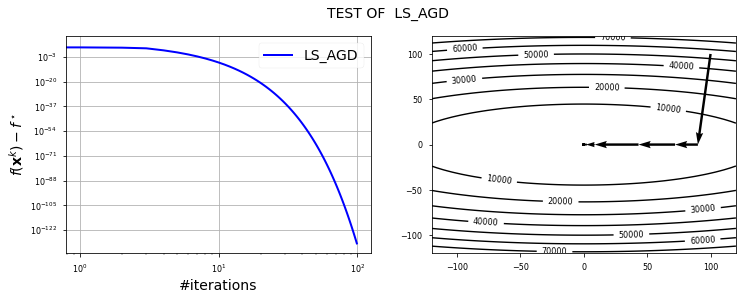

In [28]:
test(LS_AGD)

__(d)__ (6 points) The accelerated gradient method is non-monotonic, so it can be oscillatory, i.e. $f_\mu(\mathbf{x}^{k+1})\not\leq f_\mu(\mathbf{x}^k)$ for all $k\geq 0$.
To prevent such behavior, we can use the so-called adaptive restart strategy. 
In short, this strategy can be explained as follows: 
At each iteration, whenever $\mathbf{x}^{k+1}$ is computed, we evaluate $f_\mu(\mathbf{x}^{k+1})$ and compare it with $f_\mu(\mathbf{x}^k)$: 

* If $f_\mu(\mathbf{x}^k) < f_\mu(\mathbf{x}^{k+1})$, restart the iteration, i.e., recompute $\mathbf{x}^{k+1}$ by setting $\mathbf{y}^{k} := \mathbf{x}^{k}$ and $t_{k} := 1$;
* Otherwise, let the algorithm continue.


This strategy requires the evaluation of the function value at each iteration, which increases the computational complexity of the overall algorithm. 

Implement the adaptive restart strategy which uses the function values for the accelerated gradient algorithm with constant step-size $\alpha_k=1/L$ 
by completing the function:

In [29]:
@dataclass
class AGDR_state(AGD_state):
    pass

In [30]:
def AGDR_update(f, state):
    x_k, y_k, t_k, alpha_k = state
    
    next_x_k = y_k - alpha_k * f.grad(y_k)
    
    if( f(next_x_k) > f(x_k)):
        y_k = x_k
        t_k = 1
        next_x_k = y_k - alpha_k * f.grad(y_k)
    
    next_t_k = (1+ (1+4*t_k**2)**0.5)/2
    next_y_k = next_x_k + (t_k - 1)*(next_x_k - x_k)/next_t_k
    next_alpha_k = 1/f.lips_grad
    
    return AGD_state(x_k = next_x_k, y_k = next_y_k, t_k=next_t_k, alpha_k =next_alpha_k)

AGDR_initialize = AGD_initialize

In [31]:
AGDR = OptAlgorithm(name="AGDR", init_state = AGDR_initialize, state_update=AGDR_update)

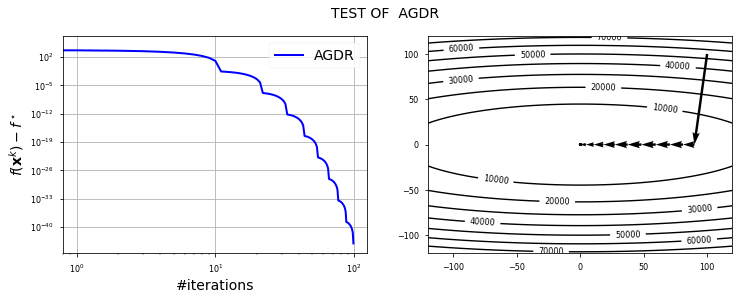

In [32]:
test(AGDR)

__(e)__ (Self-study, 0 points)
Incorporate the line-search, acceleration and function values restart by completing the function LSAGDR. 

**Hint:** Note that while the restart is executed on $\mathbf{x}^k$, the line-search strategy is executed on $\mathbf{y}^k$ and the direction $\mathbf{d}^k=-\nabla f(\mathbf{y}^k)$ to determine the 
step-size and hence, use line-search each time you encounter an intermediate variable $\mathbf{y}^k$.

In [33]:
@dataclass 
class LS_AGDR_state(OptState):
    pass

In [34]:
def LS_AGDR_update(f, state):
    
    x_k, y_k, t_k, alpha_k = state

    d_k = - f.grad(x_k)
    L_k = 1/alpha_k
    L_k0 = L_k/2

    i = 0
    while( f(x_k + d_k/(2**i * L_k0)) > f(x_k) - d_k.dot(d_k)/(2**(i+1) * L_k0)):
        i+=1

    next_L_k = 2**i * L_k0
    next_alpha_k = 1/next_L_k

    next_x_k = x_k + alpha_k * d_k

    if( f(next_x_k) > f(x_k)):
        y_k = x_k
        t_k = 1
        next_x_k = y_k - next_alpha_k * f.grad(y_k)

    next_t_k = (1+ (1+4*t_k**2)**0.5)/2
    next_y_k = next_x_k + (t_k - 1)*(next_x_k - x_k)/next_t_k

    return AGD_state(x_k = next_x_k, y_k = next_y_k, t_k=next_t_k, alpha_k =next_alpha_k)

def LS_AGDR_initialize(f, x_zero):
    x_k = x_zero
    y_k = x_zero
    t_k = 1
    alpha_k = 1/f.lips_grad
    
    return AGD_state(x_k, y_k, t_k, alpha_k)

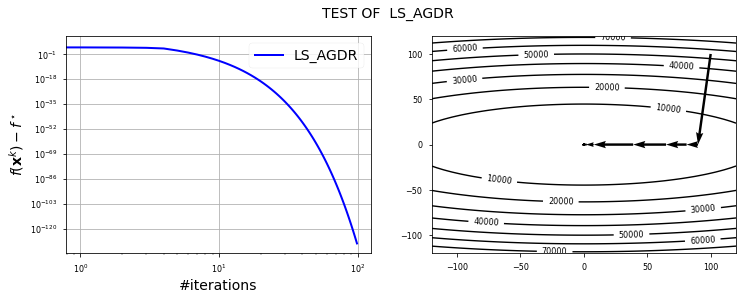

In [35]:
LS_AGDR = OptAlgorithm(name="LS_AGDR", init_state=LS_AGDR_initialize, state_update=LS_AGDR_update)

test(LS_AGDR)

__(f)__ (5 points) We can also apply an optimization technique that does not exploit the knowledge of the Lipschitz constant, and instead adapts to the local geometry by making use of past gradient information. AdaGrad adapts the step-size using the inverse square $\ell_2$-norm of past gradients. Starting with $Q_0 = 0$ it iterates as follows:

\begin{equation*}
\left\{
\begin{array}{ll}
Q_k &{\!\!\!\!}= Q_{k-1} + \|\nabla f_\mu(\mathbf{x}^k)\|^2 \\
\mathbf{H}_k &{\!\!\!\!}= (\sqrt{Q_k} + \delta) I \\
\mathbf{x}^{k+1} &{\!\!\!\!}= \mathbf{x}^k - \alpha \mathbf{H}_k^{-1} \nabla f_\mu(\mathbf{x}^k)
\end{array}
\right.
\end{equation*}

Complete the missing parts in the function AdaGrad in order to implement the above adaptive gradient method using $\alpha = 1$, $\delta = 10^{-5}$.

In [36]:
@dataclass
class AdaGrad_state(OptState):
    x_k: Vector
    Q_k: float
    alpha: float
    delta: float

In [37]:
def AdaGrad_update(f, state):
    x_k, Q_k, alpha, delta = state
    
    next_Q_k = Q_k + f.grad(x_k).dot(f.grad(x_k))
    
    H_k = (next_Q_k**0.5 + delta)
    
    next_x_k = x_k - alpha*f.grad(x_k)/H_k
    
    
    return AdaGrad_state(next_x_k, next_Q_k, alpha, delta)

def AdaGrad_initialize(f, x_zero):
    return AdaGrad_state(x_zero, 0.0, 1, 10**(-5))

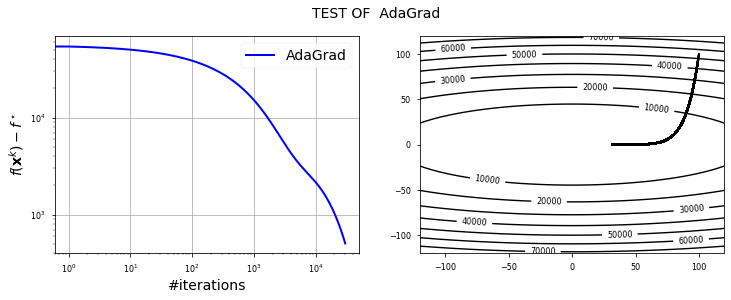

In [38]:
AdaGrad = OptAlgorithm(name="AdaGrad", init_state=AdaGrad_initialize, state_update=AdaGrad_update)
test(AdaGrad, maxiter=30000)

__(g)__ (Self study, 0 points) Another famous adaptive optimization method is called the ADAptive Moment estimation algorithm, also known as ADAM, 

\begin{equation*}
\left\{
\begin{array}{ll}
\mathbf{g}_k &{\!\!\!\!} = \nabla f_\mu(\mathbf{x}^{k}) \\
\mathbf{m}_{k+1} &{\!\!\!\!} = \beta_1 \mathbf{m}_{k} + (1-\beta_1)\mathbf{g}_k \ \textrm{$\leftarrow$ Momentum}\\
\mathbf{v}_{k+1} &{\!\!\!\!} = \beta_2 \mathbf{v}_{k} + (1-\beta_2)\mathbf{g}_k^2 \ \textrm{$\leftarrow$ Adaptive term}\\
\hat{\mathbf{m}}_{k+1} &{\!\!\!\!} = \mathbf{m}_k / (1-\beta_1^{k+1})\\
\hat{\mathbf{v}}_{k+1} &{\!\!\!\!} = \mathbf{v}_k / (1-\beta_2^{k+1}) \ \textrm{$\leftarrow$ Scaling for removing bias}\\
\mathbf{H}_{k+1} &{\!\!\!\!} \ = \sqrt{\hat{\mathbf{v}}_{k+1}} + \epsilon \\
\mathbf{x}^{k+1} &{\!\!\!\!} = \mathbf{x}^k - \alpha \hat{\mathbf{m}}_{k+1} / \mathbf{H}_{k+1}
\end{array}
\right.
\end{equation*}

Note that all operations shown above, when applied to vectors, are applied element-wise. In particular, $\mathbf{g}_k^2$ is a vector of the same size as $\mathbf{g}_k$ where each element is squared.

Complete the missing parts in the file \url{algorithms.ADAM} in order to implement the above adaptive gradient method using $\alpha = 0.1$, $\beta_1 = 0.9$, $\beta_2 = 0.999$ and $\epsilon = 10^{-8}$.

It has been shown that ADAM can fail to converge to the global minimum of a convex problem. The authors provided a variant of ADAM, called AMSgrad in order to fix this convergence issue. However, in practice it is not clear which method performs best. (You are not required to implement this method, but advised to have a look at it for personal interest).

In [39]:
@dataclass
class ADAM_state(OptState):
    x_k: Vector
    #FILL

In [ ]:
def ADAM_update(f, state):
    #FILL

def ADAM_initialize(f, x_zero):
    #FILL

In [ ]:
ADAM = OptAlgorithm(name="ADAM", init_state=ADAM_initialize, state_update=ADAM_update)

test(ADAM, maxiter=1000)

## Running the methods - 1 Point


With these iterative shemes implemented, we will try to solve one logistic regression problem.

We are going to model the probablity that a basketball shot succesfully enters the net using the logistic model introduced in the first part of the homework.

Our data originates from motion tracking data captured by the NBA during the 2015-2016 season. <a name="cite_ref-2"></a>[<sup>[1]</sup>](#cite_note-2)

<img width=50% src='lib/golden_state_shots.png'/>

We consider the `3376` shots made by the Golden State Warriors. The labels ${b}_i$ will correspond to whether or not the shot $i$ was succesful, and $\mathbf{a}_i$ will be a feature vector of dimension 5 containing the x-location, the y-location (of the player shooting on the basketball court), the distance to the basket, the number of minutes and the number of seconds left before the end of the quarter.

The following cell runs the methods you have implemented on the logistic loss:

AdaGrad: 100%|██████████| 5000/5000 [00:05<00:00, 904.39it/s]


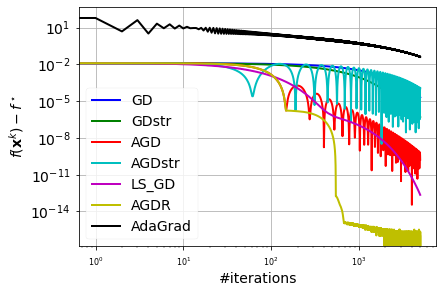

In [41]:
from lib.part_one import f, x_zero, train_accuracy

#Remove methods you have not implemented
methods = [GD, GDstr, AGD, AGDstr, LS_GD, AGDR, AdaGrad]

plot(methods, f, x_zero, max_iteration=5000)

Briefly comment on the plot, mention if what you observe lines up with the theory you have seen.

Comment: From the plots we observe that AGDR performs the best with the lowest value for $f(x^k) - f^*$ and the fastest convergence for the chosen no. of iterations. This maybe due to the fact that it restarts when the update does not reduce $f(x)$, leading to better and faster convergence compared to GD, GDstr and AGD.

Pick the best performing method and run the following cell to display the training accuracy of your solution:

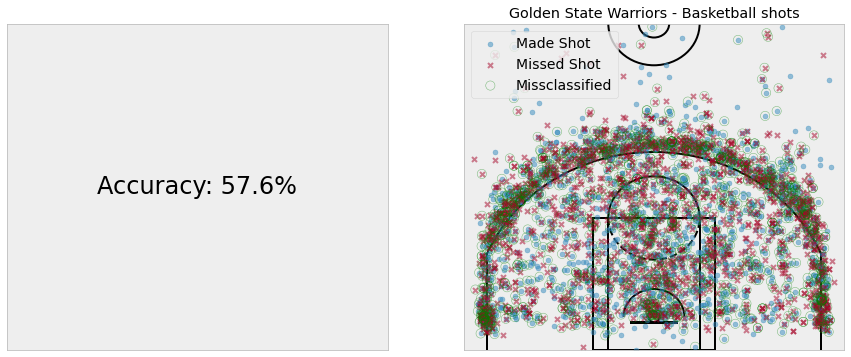

In [42]:
method = AGDR
run_trace = run(method, f, x_zero, 5000)
last_x_k = run_trace.sequence[-1]

train_accuracy(run_trace.sequence[-1])

To improve our model, we can try using more data.

We actually have access to as many as `84467` distinct shots from all teams that played in 2015-2016. 

That means that our objective function will be the sum of $n = 84467$ terms. Computing this many gradients is expensive, and will slow down our deterministic methods.

In the next notebook, you will use stochastic methods in order to reduce the computational cost of a single iteration.

<a name="cite_note-2"></a>1. [^](#cite_ref-2) https://github.com/sealneaward/nba-movement-data MIT License Copyright (c) 2016 Neil Seward